In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spike_generators import GutniskyUnivariateSpikeGenerator, KaulakysUnivariateSpikeGenerator

In [2]:
mean_spiking_rate = 1
spike_train_length = 100
spike_train_autocov = 1 / np.arange(1, spike_train_length + 1)

#### Gutnisky

Accepts a neuron's mean spiking rate and a vector of autocovariances between spikes $[Cov(y_t, y_t), Cov(y_t, y_{t-1}), \ldots, Cov(y_t, y_{t-k})]$. Outputs the generated spike train and interspike times.

**Note:** it is randomized algorithm, so it needs to be re-run until the desired PSD is produced.

In [15]:
sp_gen_gutisky = GutniskyUnivariateSpikeGenerator()
train, times = sp_gen_gutisky.get_spike_train(mean_spiking_rate, spike_train_autocov)

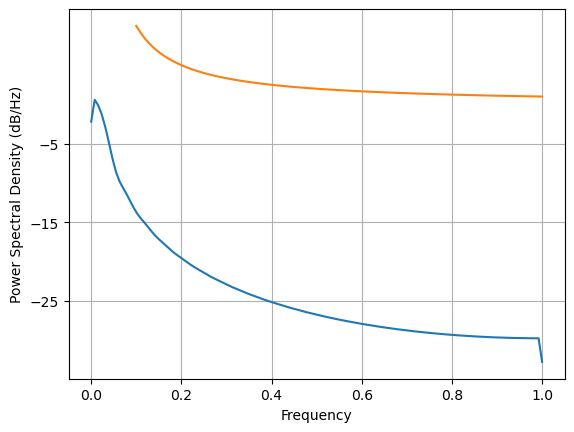

In [16]:
plt.psd(times);

# Also plot 1/f
x = np.linspace(0.1, 1, 100)
plt.plot(x, 1/x)

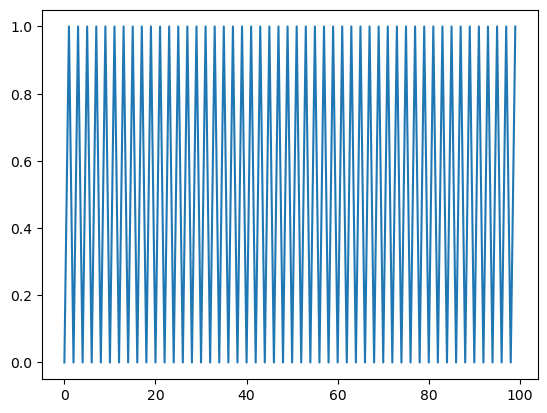

In [17]:
plt.plot(train)

#### Kaulakys

Accepts a neuron's mean spiking rate and length of the spike train. Outputs the generated spike train and interspike times correlated as $1/f$.

**Note:** it is randomized algorithm, so it needs to be re-run until the desired PSD is produced.

In [3]:
sp_gen_kaulakys = KaulakysUnivariateSpikeGenerator()
train, times = sp_gen_kaulakys.get_spike_train(mean_spiking_rate, spike_train_length)

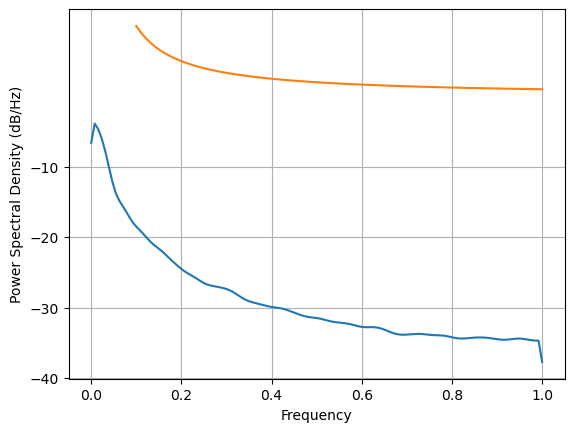

In [4]:
plt.psd(times);

# Also plot 1/f
x = np.linspace(0.1, 1, 100)
plt.plot(x, 1/x)

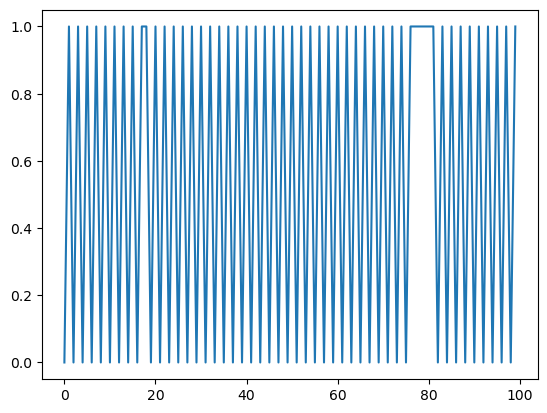

In [5]:
plt.plot(train)